In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.special import expit, logsumexp
import matplotlib.pyplot as plt
import cvxpy as cvx
from itertools import product

### NOTE: Skip down to "Generate Plots" section, the rest was for testing and debugging

In [2]:
cvx.__version__

'1.0.24'

In [3]:
rng = default_rng()

In [4]:
def log1pexp(x):
    # log(1 + e^x)
    # for scipy>=1.8.0, can use log_expit instead
    return -np.log(expit(-x))

### Create box

In [5]:
d = 3

In [6]:
# Randomly generate lower and upper bounds
mid = rng.standard_normal(d)
eps = np.abs(rng.standard_normal(d))
l = mid - eps
u = mid + eps
np.vstack((l, u))

array([[-2.63711118,  0.60782952, -1.54592334],
       [ 0.47287766,  0.67623786,  0.75968638]])

### Constant bounds

WLOG consider the first output of softmax (corresponding to input 1)

Constant bounds on log softmax

In [7]:
diffs_l = l[1:] - u[0]
diffs_u = u[1:] - l[0]
diffs_l, diffs_u

(array([ 0.13495186, -2.018801  ]), array([3.31334904, 3.39679756]))

In [8]:
lsm_l = -log1pexp(logsumexp(diffs_u))
lsm_u = -log1pexp(logsumexp(diffs_l))
lsm_l, lsm_u

(-4.066378607211358, -0.8229889054846288)

Constant bounds on softmax

In [9]:
sm_l = np.exp(lsm_l)
sm_u = np.exp(lsm_u)
print(sm_l, sm_u)
print(f'sm_u - sm_l gap = {sm_u - sm_l}')

0.01713934455495628 0.4391172112700949
sm_u - sm_l gap = 0.4219778667151386


### Variable upper bounds

In [10]:
x = cvx.Variable(d)

In [11]:
cons = [l <= x, x <= u]

Exponential-reciprocal upper bound:

In [12]:
ER_u = sm_l + sm_u - sm_l * sm_u * (1 + cvx.sum(cvx.exp(x[1:] - x[0])))
ER_u

Expression(CONCAVE, UNKNOWN, ())

Log-sum-exp upper bound:

In [40]:
LSE_u = (lsm_u * sm_l - lsm_l * sm_u - (sm_u - sm_l) * (cvx.log_sum_exp(x) - x[0])) / (lsm_u - lsm_l)
LSE_u

Expression(CONCAVE, UNKNOWN, ())

In [41]:
obj = cvx.Maximize(ER_u - sm_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'ER_u - sm_l gap = {gap}')

ER_u - sm_l gap = 0.42197786436744356


In [42]:
obj = cvx.Maximize(LSE_u - sm_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'LSE_u - sm_l gap = {gap}')

LSE_u - sm_l gap = 0.4219778654939097


Linear upper bound of Shi et al. (ICLR 2020) and Bonaert et al. (PLDI 2021):

In [43]:
# Tangent points for bounding exponentials from below
#print(np.log((np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)))
#print(diffs_l + 1)
diffs_t = np.minimum(np.log((np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)), diffs_l + 1)
diffs_t

array([ 1.13495186, -1.018801  ])

In [44]:
# Lower and upper bounds on denominator of softmax
den_l = 1 + np.dot(np.exp(diffs_t), diffs_l - diffs_t + 1)
den_u = 1 + np.exp(diffs_u).sum()
den_l, den_u

(1.0, 58.34528833897699)

In [45]:
lin_u = 1 / den_l + 1 / den_u - 1 / (den_l * den_u) * (1 + np.exp(diffs_t) @ (x[1:] - x[0] - diffs_t + 1))
lin_u

Expression(AFFINE, UNKNOWN, ())

In [19]:
obj = cvx.Maximize(lin_u - sm_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'lin_u - sm_l gap = {gap}')

lin_u - sm_l gap = 0.9828606554450438


### Variable lower bounds

Exponential-reciprocal lower bound:

In [20]:
diffs = x[1:] - x[0]
ER_l = cvx.power(1 + cvx.sum((cvx.multiply(diffs_u - diffs, np.exp(diffs_l)) + cvx.multiply(diffs - diffs_l, np.exp(diffs_u))) / (diffs_u - diffs_l)), -1)
ER_l

Expression(CONVEX, NONNEGATIVE, ())

In [21]:
obj = cvx.Maximize(sm_u - ER_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'sm_u - ER_l gap = {gap}')

sm_u - ER_l gap = 0.4219778666722281


In [22]:
obj = cvx.Maximize(ER_u - ER_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'ER_u - ER_l gap = {gap}')

ER_u - ER_l gap = 0.3733569570382391


In [23]:
print(x.value)
print((x.value - l) / (u - l))

[-0.20754769  0.64231362  0.23094514]
[0.78121293 0.50409193 0.77067184]


In [24]:
obj = cvx.Maximize(LSE_u - ER_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'LSE_u - ER_l gap = {gap}')

LSE_u - ER_l gap = 0.3234465406253219


In [25]:
print(x.value)
print((x.value - l) / (u - l))

[0.43945405 0.62874222 0.21737622]
[0.98925282 0.30570386 0.76478666]


Log-sum-exp lower bound:

In [26]:
lse_l = logsumexp(l[1:]) - u[0]
lse_u = logsumexp(u[1:]) - l[0]
lse_l, lse_u

(0.24474557745043435, 4.049090683948879)

In [27]:
if d == 2:
    diff = x[1] - x[0]
else:
    diff = cvx.log(cvx.sum((cvx.multiply(u[1:] - x[1:], np.exp(l[1:])) + cvx.multiply(x[1:] - l[1:], np.exp(u[1:]))) / (u[1:] - l[1:]))) - x[0]
diff

Expression(CONCAVE, UNKNOWN, ())

In [28]:
lb_cons = False
if lb_cons:
    LSE_l = cvx.Variable()
    cons_LSE_l = cvx.log(LSE_l) >= (lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * diff) / (lse_u - lse_l)
    cons_LSE_l
else:
    LSE_l = cvx.exp((lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * diff) / (lse_u - lse_l))
    LSE_l

In [29]:
obj = cvx.Maximize(sm_u - LSE_l)
prob = cvx.Problem(obj, cons + [cons_LSE_l] if lb_cons else cons)
gap = prob.solve(solver='SCS')
print(f'sm_u - LSE_l gap = {gap}')

sm_u - LSE_l gap = 0.4219778545182951


In [30]:
obj = cvx.Maximize(LSE_u - LSE_l)
prob = cvx.Problem(obj, cons + [cons_LSE_l] if lb_cons else cons)
gap = prob.solve()
print(f'LSE_u - LSE_l gap = {gap}')

LSE_u - LSE_l gap = 0.19591776367074698


In [31]:
print(x.value)
print((x.value - l) / (u - l))

[-0.6029355   0.60782953 -0.36251271]
[6.54078126e-01 1.60363299e-07 5.13274479e-01]


In [32]:
obj = cvx.Maximize(ER_u - LSE_l)
prob = cvx.Problem(obj, cons + [cons_LSE_l] if lb_cons else cons)
gap = prob.solve()
print(f'ER_u - LSE_l gap = {gap}')

ER_u - LSE_l gap = 0.3100272121668307


In [33]:
print(x.value)
print((x.value - l) / (u - l))

[-1.20870723  0.60782956 -0.36251441]
[4.59295520e-01 5.69134852e-07 5.13273742e-01]


Linear lower bound of Shi et al. (ICLR 2020) and Bonaert et al. (PLDI 2021):

In [34]:
# Tangent point for bounding reciprocal from below
den_t = max(np.sqrt(den_l * den_u), den_u / 2)
den_t

29.172644169488496

In [35]:
lin_l = 1 / den_t * (2 - 1 / den_t * (1 + cvx.sum((cvx.multiply(diffs_u - diffs, np.exp(diffs_l)) + cvx.multiply(diffs - diffs_l, np.exp(diffs_u))) / (diffs_u - diffs_l))) )
lin_l

Expression(AFFINE, UNKNOWN, ())

In [36]:
obj = cvx.Maximize(sm_u - lin_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'sm_u - lin_l gap = {gap}')

sm_u - lin_l gap = 0.4391172112700949


In [37]:
obj = cvx.Maximize(lin_u - lin_l)
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'lin_u - lin_l gap = {gap}')

lin_u - lin_l gap = 0.9347271105235131


In [38]:
obj = cvx.Maximize(cvx.minimum(lin_u, sm_u) - cvx.maximum(lin_l, sm_l))
prob = cvx.Problem(obj, cons)
gap = prob.solve()
print(f'lin_u - lin_l gap = {gap}')

lin_u - lin_l gap = 0.42197414262477145


### Generate plots

In [2]:
import pickle

Parameters:

In [3]:
# Dimensions
ds = [2, 3, 4, 5, 6, 8, 11, 16, 23, 32, 45, 64, 91, 128]
num_ds = len(ds)

In [4]:
# Largest mean component of Dirichlet distribution
muMax = np.array([0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.998, 0.999])
#alphaMax = (d - 1) * muMax / (1 - muMax)
#alphaMax = np.insert(alphaMax, 0, 1)
num_alphaMax = len(muMax) + 1

In [5]:
# Input bounds
eps = [0.01, 0.1, 0.2, 0.5, 1, 2, 5]
num_eps = len(eps)

In [46]:
# Bounds
from itertools import product

lbs = ['sm_l', 'lin_l', 'ER_l', 'hybrid_l', 'hybrid2_l', 'LSE_l']
ubs = ['sm_u', 'lin_u', 'ER_u', 'LSE_u']
lbs_labels = ['const', '$L^{lin}$', '$L^{ER}$', '$L^{LSE_1}$', '$L^{LSE_2}$', '$L^{LSE_3}$']
ubs_labels = ['const', '$U^{lin}$', '$U^{ER}$', '$U^{LSE}$']
#pairs = list(product(['ER_l', 'LSE_l', 'hybrid_l'], ['ER_u', 'LSE_u'])) + [('lin_l', 'lin_u')]
#pairs

Initialize arrays:

In [47]:
R = 100

mean_sm_l = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_ER_l = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_LSE_l = np.zeros((R, num_ds, 2, num_alphaMax,  num_eps))
mean_hybrid_l = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_hybrid2_l = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_lin_l = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))

#mean_sm_l_sem = np.zeros((num_ds, num_eps))
#mean_ER_l_sem = np.zeros((num_ds, num_eps))
#mean_LSE_l_sem = np.zeros((num_ds, num_eps))
#mean_hybrid_l_sem = np.zeros((num_ds, num_eps))
#mean_lin_l_sem = np.zeros((num_ds, num_eps))

mean_sm_u = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_ER_u = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_LSE_u = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))
mean_lin_u = np.zeros((R, num_ds, 2, num_alphaMax, num_eps))

#mean_sm_u_sem = np.zeros((num_ds, num_eps))
#mean_ER_u_sem = np.zeros((num_ds, num_eps))
#mean_LSE_u_sem = np.zeros((num_ds, num_eps))
#mean_lin_u_sem = np.zeros((num_ds, num_eps))

#sm_u_sm_l = np.zeros((num_ds, num_eps))
#max_ER_u_ER_l = np.zeros((num_ds, num_eps))
#max_ER_u_LSE_l = np.zeros((num_ds, num_eps))
#max_ER_u_hybrid_l = np.zeros((num_ds, num_eps))
#max_LSE_u_ER_l = np.zeros((num_ds, num_eps))
#max_LSE_u_LSE_l = np.zeros((num_ds, num_eps))
#max_LSE_u_hybrid_l = np.zeros((num_ds, num_eps))
#max_lin_u_lin_l = np.zeros((num_ds, num_eps))

Load data:

In [48]:
from scipy.stats import sem

for dd, d in enumerate(ds):
    #with open(f'LSE_ER_lin_2022-07-07_d{d}.pkl', 'rb') as f:
    with open(f'results/LSE_ER_lin_2022-10-03_d{d}.pkl', 'rb') as f:
        res = pickle.load(f)
        
    #sm_u_sm_l[dd, :] = res['sm_u_sm_l'].mean(axis=0)
    #for lb, ub in pairs:
        #eval('max_' + ub + '_' + lb)[dd, :] = res['max_' + ub + '_' + lb].mean(axis=0)
        #eval('max_' + ub + '_' + lb)[dd, :] = (res['max_' + ub + '_' + lb] / res['sm_u_sm_l']).mean(axis=0)
    for lb in lbs:
        #eval('mean_' + lb)[dd, :] = res['mean_' + lb].mean(axis=0)
        #eval('mean_' + lb)[dd, :] = (res['mean_' + lb] / res['mean_sm_l']).mean(axis=0)
        eval('mean_' + lb)[:, dd, :, :, :] = res['mean_' + lb]
        #eval('mean_' + lb + '_sem')[dd, :] = sem(res['mean_' + lb] / res['mean_sm_l'], axis=0)
        #eval('mean_' + lb + '_sem')[dd, :] = (res['mean_' + lb] / res['mean_sm_l']).std(axis=0)
    for ub in ubs:
        #eval('mean_' + ub)[dd, :] = res['mean_' + ub].mean(axis=0)
        #eval('mean_' + ub)[dd, :] = (res['mean_' + ub] / res['mean_sm_u']).mean(axis=0)
        eval('mean_' + ub)[:, dd, :, :, :] = res['mean_' + ub]
        #eval('mean_' + ub + '_sem')[dd, :] = sem(res['mean_' + ub] / res['mean_sm_u'], axis=0)
        #eval('mean_' + ub + '_sem')[dd, :] = (res['mean_' + ub] / res['mean_sm_u']).std(axis=0)

In [53]:
# Replace hybrid_l with LSE_l for d = 2
mean_hybrid_l[:, 0, :, :, :] = mean_LSE_l[:, 0, :, :, :]
mean_hybrid2_l[:, 0, :, :, :] = mean_LSE_l[:, 0, :, :, :]

In [43]:
# Drop alternative LSE lower bound
lbs.pop()
lbs_labels.pop()

'$L^{LSE_3}$'

Gaussian data - mean gap vs. dimension:

In [12]:
# Iterate over lower and upper bounds
for lu in ['l', 'u']:
    bs = lu + 'bs'
    divide_by = 'sm_' + lu
    #divide_by = None
    
    #ep = 0.5
    #ee = eps.index(ep)
    for ee in range(num_eps):

        plt.figure(figsize=(2.7, 2.7))
        handles = [None] * (len(eval(bs)) - int(divide_by is not None))
        idx = 0
        for b in eval(bs):
            #plt.loglog(ds, eval('mean_' + lb)[:, ee])
            #plt.plot(ds, eval('mean_' + lb)[:, ee])
            if divide_by is not None:
                qty = eval('mean_' + b)[:, :, ee] / eval('mean_' + divide_by)[:, :, ee]
            else:
                qty = eval('mean_' + b)[:, :, ee]
            qty_mean = qty.mean(axis=0)
            qty_sem = sem(qty, axis=0)
            if divide_by is not None and b == divide_by:
                # Just draw horizontal dashed line
                #plt.axhline(1, c='k', linestyle='--')
                continue
            else:
                handles[idx], = plt.plot(ds, qty_mean)
                idx += 1
                plt.fill_between(ds, qty_mean - qty_sem, qty_mean + qty_sem, alpha=0.5)

        plt.xscale('log')
        plt.yscale('log')
        plt.grid(which='major', axis='x')
        plt.grid(which='both', axis='y')
        plt.legend(handles, eval(bs + '_labels')[int(divide_by is not None):])
        plt.xlabel('input dimension')
        if divide_by is not None:
            #plt.ylabel('mean gap relative to constant bound')
            plt.ylabel('mean gap rel. to const. bound')
        else:
            plt.ylabel('mean gap')
        #plt.title('mean gap between softmax and lower bound')

        filename = 'synth_' + bs
        if divide_by is not None:
            filename += '_rel'
        filename += f'_eps{int(100 * eps[ee])}'
        print(filename)

        plt.savefig('figures/' + filename + '.pdf', bbox_inches='tight')
        plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (14,) and (14, 10, 7)

Dirichlet data - mean gap vs. largest mean component:

synth_lbs_rel_d16_high_eps20


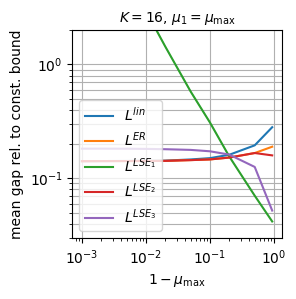

synth_lbs_rel_d16_high_eps200


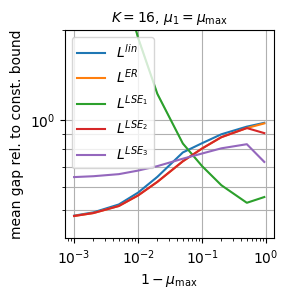

synth_lbs_rel_d16_low_eps20


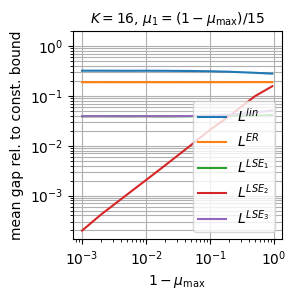

synth_lbs_rel_d16_low_eps200


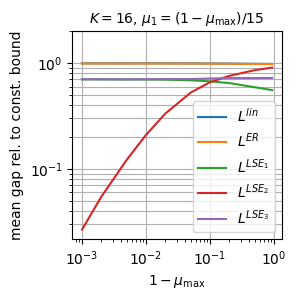

synth_ubs_rel_d16_high_eps20


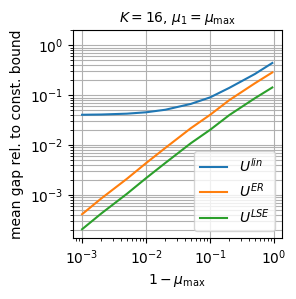

synth_ubs_rel_d16_high_eps200


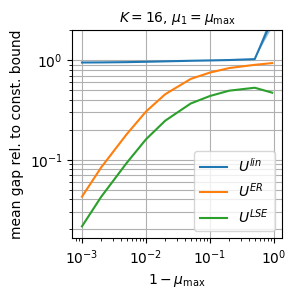

synth_ubs_rel_d16_low_eps20


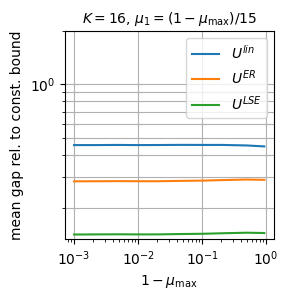

synth_ubs_rel_d16_low_eps200


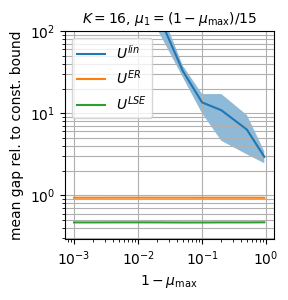

In [55]:
d = 16
dd = ds.index(d)

# Iterate over lower and upper bounds
for lu in ['l', 'u']:
    bs = lu + 'bs'
    divide_by = 'sm_' + lu
    #divide_by = None
    
    # Iterate over high and low probability
    for mm in range(2):
        
        #ep = 0.5
        #ee = eps.index(ep)
        #for ee in range(num_eps):
        #for ee in [4]:
        for ee in [2, 5]:

            if divide_by is None:
                plt.figure(figsize=(4., 4.))
            else:
                plt.figure(figsize=(2.7, 2.7))
            handles = [None] * (len(eval(bs)) - int(divide_by is not None))
            idx = 0
            for b in eval(bs):
                #plt.loglog(ds, eval('mean_' + lb)[:, ee])
                #plt.plot(ds, eval('mean_' + lb)[:, ee])
                if divide_by is not None:
                    qty = eval('mean_' + b)[:, dd, mm, :, ee] / eval('mean_' + divide_by)[:, dd, mm, :, ee]
                else:
                    qty = eval('mean_' + b)[:, dd, mm, :, ee]
                qty_mean = qty.mean(axis=0)
                qty_sem = sem(qty, axis=0)
                if divide_by is not None and b == divide_by:
                    # Just draw horizontal dashed line
                    #plt.axhline(1, c='k', linestyle='--')
                    continue
                else:
                    handles[idx], = plt.plot(1 - np.insert(muMax, 0, 1/d), qty_mean)
                    idx += 1
                    plt.fill_between(1 - np.insert(muMax, 0, 1/d), qty_mean - qty_sem, qty_mean + qty_sem, alpha=0.5)

            plt.xscale('log')
            plt.yscale('log')
            if divide_by is not None:
                if lu == 'u' and mm == 1 and eps[ee] > 0.2:
                    plt.ylim(top=100)
                else:
                    plt.ylim(top=2)
            plt.grid(which='major', axis='x')
            plt.grid(which='both', axis='y')
            if (lu == 'l' and mm == 0) or (lu == 'u' and mm == 1):
                plt.tick_params(axis='y', which='minor', labelleft=False)

            labels = eval(bs + '_labels')[int(divide_by is not None):]
            if d == 2 and lu == 'l':
                # Change label for LSE lower bound if d = 2
                labels[-1] = '$L^{LSE}$ (24)'
            plt.legend(handles, labels)
            plt.xlabel(r'$1 - \mu_{\max}$')
            if divide_by is not None:
                #plt.ylabel('mean gap relative to constant bound')
                plt.ylabel('mean gap rel. to const. bound')
            else:
                plt.ylabel('mean gap')
            if mm == 1:
                plt.title(f'$K={d}$, ' + r'$\mu_1=(1-\mu_{\max})/$' + f'${d-1}$', fontsize='medium')
            else:
                plt.title(f'$K={d}$, ' + r'$\mu_1=\mu_{\max}$', fontsize='medium')

            filename = 'synth_' + bs
            if divide_by is not None:
                filename += '_rel'
            lh = 'low' if mm == 1 else 'high'
            filename += f'_d{d}_{lh}_eps{int(100 * eps[ee])}'
            print(filename)

            plt.savefig('figures/' + filename + '.pdf', bbox_inches='tight')
            plt.show()

Gaussian data - mean gap ratio vs. d:

synth_ER_l_hybrid_l_eps1


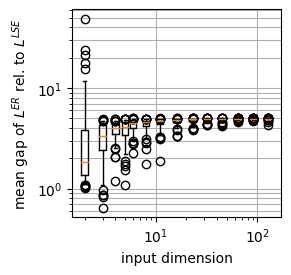

synth_ER_l_hybrid_l_eps10


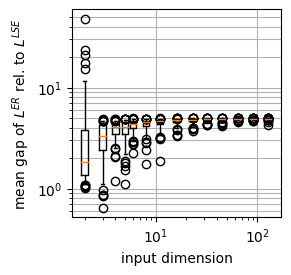

synth_ER_l_hybrid_l_eps20


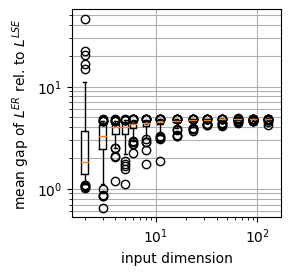

synth_ER_l_hybrid_l_eps50


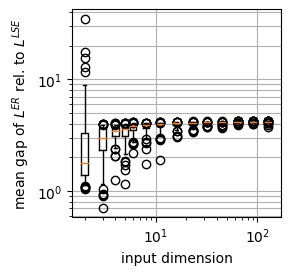

synth_ER_l_hybrid_l_eps100


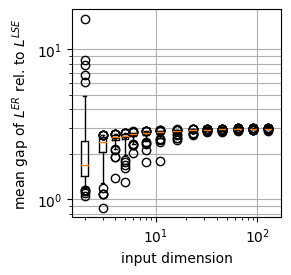

synth_ER_u_LSE_u_eps1


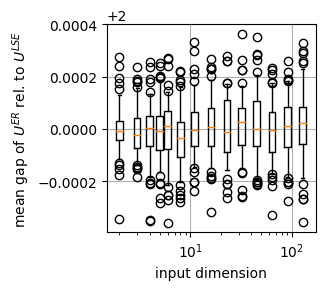

synth_ER_u_LSE_u_eps10


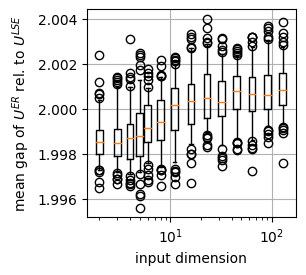

synth_ER_u_LSE_u_eps20


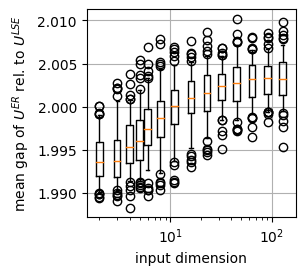

synth_ER_u_LSE_u_eps50


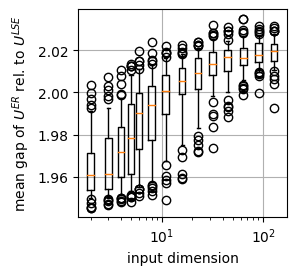

synth_ER_u_LSE_u_eps100


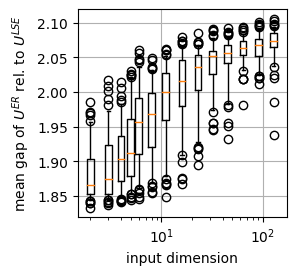

In [172]:
idx_num = 2
idx_den = 3

for bs in ['lbs', 'ubs']:
    #ep = 0.2
    #ee = eps.index(ep)
    for ee in range(num_eps):

        plt.figure(figsize=(2.7, 2.7))
        
        qty = eval('mean_' + eval(bs)[idx_num])[:, :, ee] / eval('mean_' + eval(bs)[idx_den])[:, :, ee]
        plt.boxplot(qty, whis=(5, 95), positions=ds, widths=0.15*np.array(ds), patch_artist=False)

        plt.xscale('log')
        if bs == 'lbs' and idx_den == 3:
            plt.yscale('log')
        plt.grid(which='major', axis='x')
        plt.grid(which='both', axis='y')
        plt.xlabel('input dimension')
        plt.ylabel(f'mean gap of {eval(bs + "_labels")[idx_num]} rel. to {eval(bs + "_labels")[idx_den]}')

        filename = 'synth_' + eval(bs)[idx_num] + '_' + eval(bs)[idx_den] + f'_eps{int(100 * eps[ee])}'
        print(filename)
                   
        plt.savefig('figures/' + filename + '.pdf', bbox_inches='tight')
        plt.show()

Dirichlet data - mean gap ratio vs. d:

[1.00215449 0.12207858 0.16319741 0.07722234 0.30732185 0.25047372
 0.40948796 0.5297753  0.52727752 0.60768121 0.72345204 0.75326355
 0.77080764 0.85023719]
synth_ER_l_hybrid_l_high0.8_eps20


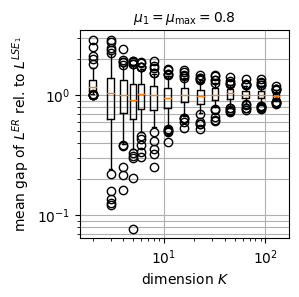

[1.0247675  0.57627105 0.68113899 0.41713223 0.96067955 0.86662101
 1.07414395 1.18761787 1.17299802 1.24158034 1.29879844 1.35831475
 1.35112756 1.37794369]
synth_ER_l_hybrid_l_high0.8_eps200


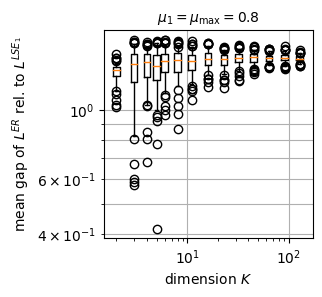

[17.50749159 25.02850303 34.54434999 33.4461344  39.32254568 53.27310389
 46.7496529  54.9021424  61.2563067  61.17426437 63.01011297 71.5896677
 73.28418224 76.36549024]
synth_ER_l_hybrid2_l_low0.99_eps20


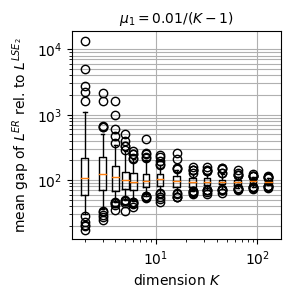

[2.18580285 2.23422146 2.45720726 2.50274097 2.65806354 3.23952192
 2.9666846  3.23199564 3.49901483 3.48642905 3.58149375 3.85224364
 3.9585337  4.06369256]
synth_ER_l_hybrid2_l_low0.99_eps200


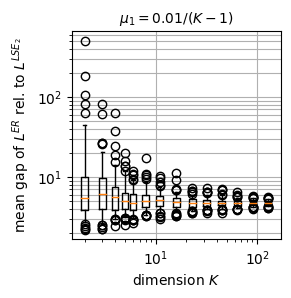

[1.98914858 1.99045774 1.98888667 1.99114707 1.98933922 1.99176123
 1.99129603 1.99208908 1.99224721 1.99217268 1.99241475 1.99178446
 1.99266219 1.9926059 ]
synth_ER_u_LSE_u_high0.8_eps20


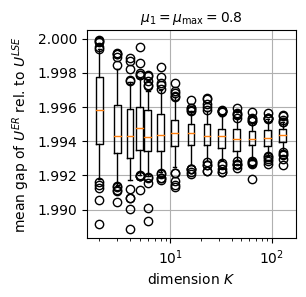

[1.65992297 1.65786224 1.65341998 1.66906635 1.66312574 1.66343553
 1.66971023 1.66709092 1.66792623 1.66552004 1.66904637 1.66797565
 1.67322588 1.66788909]
synth_ER_u_LSE_u_high0.8_eps200


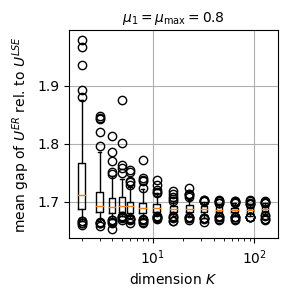

[1.99342269 1.99313156 1.99351305 1.99413513 1.99268196 1.99323314
 1.99530721 1.99494205 1.99400669 1.99465432 1.99351369 1.99423605
 1.99417599 1.99553282]
synth_ER_u_LSE_u_low0.99_eps20


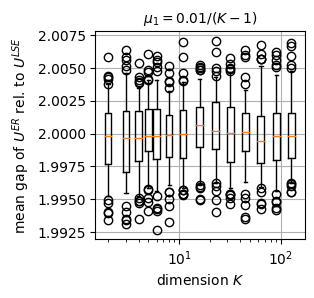

[1.81879281 1.87510315 1.90185368 1.93011322 1.93389506 1.9423145
 1.95342942 1.95195215 1.96255703 1.96240235 1.94568619 1.95640099
 1.97694903 1.96035273]
synth_ER_u_LSE_u_low0.99_eps200


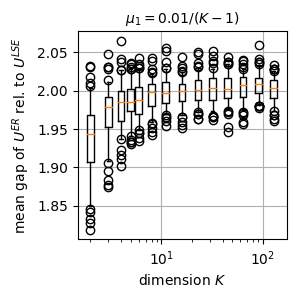

In [56]:
idx_num = 2
idx_den = 3
idx_alphaMax = [2, 6]

# Iterate over lower and upper bounds
for bs in ['lbs', 'ubs']:
    # Iterate over high and low probability
    for mm in range(2):
        #ep = 0.2
        #ee = eps.index(ep)
        #for ee in range(num_eps):
        #for ee in [4]:
        for ee in [2, 5]:

            plt.figure(figsize=(2.7, 2.7))

            if bs == 'lbs' and mm == 1:
                idx_denTmp = 4
            else:
                idx_denTmp = idx_den
            qty = eval('mean_' + eval(bs)[idx_num])[:, :, mm, idx_alphaMax[mm], ee] / eval('mean_' + eval(bs)[idx_denTmp])[:, :, mm, idx_alphaMax[mm], ee]
            print(qty.min(axis=0))
            plt.boxplot(qty, whis=(5, 95), positions=ds, widths=0.15*np.array(ds), patch_artist=False)

            plt.xscale('log')
            if bs == 'lbs' and idx_den == 3:
                plt.yscale('log')
            plt.grid(which='major', axis='x')
            plt.grid(which='both', axis='y')
            plt.xlabel('dimension $K$')
            plt.ylabel(f'mean gap of {eval(bs + "_labels")[idx_num]} rel. to {eval(bs + "_labels")[idx_denTmp]}')
            lh = 'low' if mm == 1 else 'high'
            if mm == 1:
                plt.title(r'$\mu_1=$' + f'${1-muMax[idx_alphaMax[mm]-1]:.2f}/(K-1)$', fontsize='medium')
            else:
                plt.title(r'$\mu_1=\mu_{\max}=$' + f'${muMax[idx_alphaMax[mm]-1]}$', fontsize='medium')

            filename = 'synth_' + eval(bs)[idx_num] + '_' + eval(bs)[idx_denTmp] + f'_{lh}{muMax[idx_alphaMax[mm]-1]}_eps{int(100 * eps[ee])}'
            print(filename)

            plt.savefig('figures/' + filename + '.pdf', bbox_inches='tight')
            plt.show()

### OLD

Max gap vs. d:

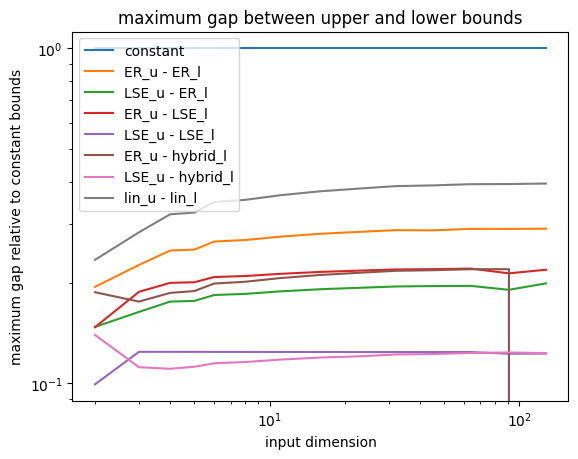

In [39]:
ep = 0.2
ee = eps.index(ep)
#plt.loglog(ds, sm_u_sm_l[:, ee])
plt.loglog(ds, sm_u_sm_l[:, ee] / sm_u_sm_l[:, ee])
for lb, ub in pairs:
    plt.loglog(ds, eval('max_' + ub + '_' + lb)[:, ee])

plt.legend(['constant'] + [ub + ' - ' + lb for lb, ub in pairs])
plt.xlabel('input dimension')
#plt.ylabel('maximum gap')
plt.ylabel('maximum gap relative to constant bounds')
plt.title('maximum gap between upper and lower bounds')
plt.show()

# 